In [81]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import kurtosis
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import scipy.stats as stats
from scipy.stats import t as student_t
from pandas.tseries.offsets import BDay

In [82]:
#Loading the dataset and converting the date column to datetime
data = pd.read_csv("/kaggle/input/gold-price-prediction-dataset/FINAL_USO.csv")
print("data shape:", data.shape)
columns_to_keep = ["Date","GDX_Adj Close"]
data = data[columns_to_keep]
data["Date"]= pd.to_datetime(data["Date"])
print(data.info())
data.head()

data shape: (1718, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718 entries, 0 to 1717
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1718 non-null   datetime64[ns]
 1   GDX_Adj Close  1718 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 27.0 KB
None


,Date,GDX_Adj Close
0,2011-12-15,48.973877
1,2011-12-16,49.921513
2,2011-12-19,48.490578
3,2011-12-20,50.215282
4,2011-12-21,50.186852


In [5]:
# Checking for any duplicates in the dataset
data.duplicated().sum()

0

In [7]:
# Checking for missing values
data.isnull().sum()

Date             0
GDX_Adj Close    0
dtype: int64

In [83]:
# Sorting data by date to maintain chronological order for time series modeling
data  =  data.sort_values("Date")
data = data.set_index("Date")
data.head(5)

,GDX_Adj Close
Date,
2011-12-15,48.973877
2011-12-16,49.921513
2011-12-19,48.490578
2011-12-20,50.215282
2011-12-21,50.186852


## Exploratory Data Analysis and Checking for basic properties of the returns series that make GARCH model suitable.
From the plot, the Gold price series exhibits a downward trend with prices generally decreasing overtime.

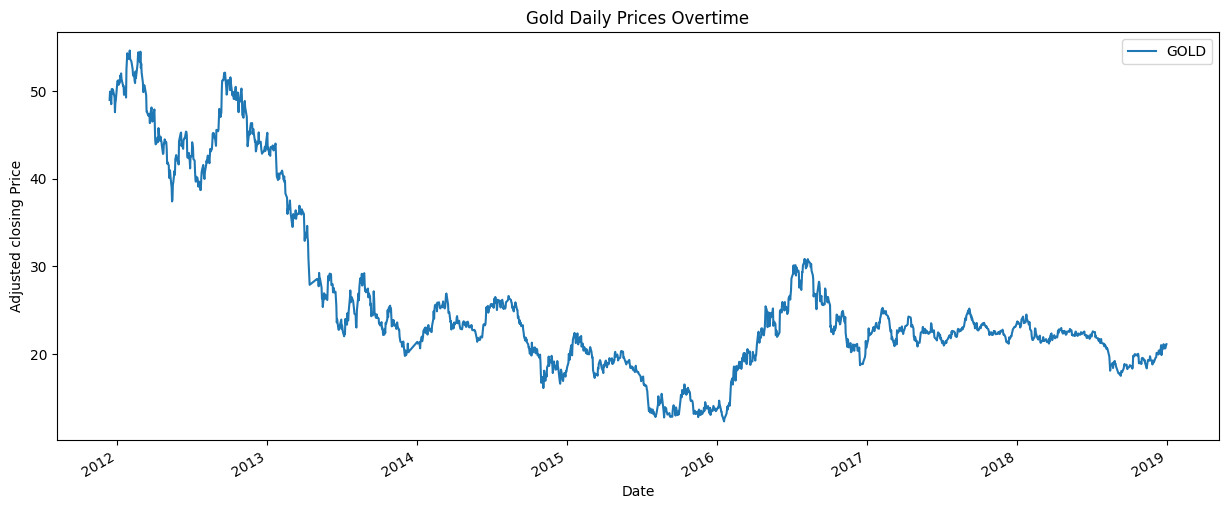

In [18]:
#Plotting Gold prices
fig, ax = plt.subplots(figsize=(15,6))
data["GDX_Adj Close"].plot(ax=ax, label= "GOLD", color= "C0")
plt.xlabel("Date")
plt.ylabel("Adjusted closing Price")
plt.title("Gold Daily Prices Overtime")
plt.legend();


In [84]:
## Calculating the daily log returns
data["log_returns"]= 100 * np.log(data["GDX_Adj Close"] / data["GDX_Adj Close"].shift(1))
# Dropping missing values since first row will be NaN due to shift
data = data.dropna()
data.head()

,GDX_Adj Close,log_returns
Date,,
2011-12-16,49.921513,1.916500
2011-12-19,48.490578,-2.908252
2011-12-20,50.215282,3.494989
2011-12-21,50.186852,-0.056632
2011-12-22,49.656178,-1.063027


In [85]:
data.tail(5)

,GDX_Adj Close,log_returns
Date,,
2018-12-24,21.090000,3.130518
2018-12-26,20.620001,-2.253747
2018-12-27,20.969999,1.683127
2018-12-28,20.600000,-1.780172
2018-12-31,21.090000,2.350792


### Visualizing the Returns
The returns series oscillate around zero, showing no persistent upward or doenward trend and appears stationary.

Moreover volatility clustering is potrayed(periods of high returns followed by periods of low returns and vice versa).

Later, the Augmented Dickey-Fuller(ADF) test will confirm stationarity.

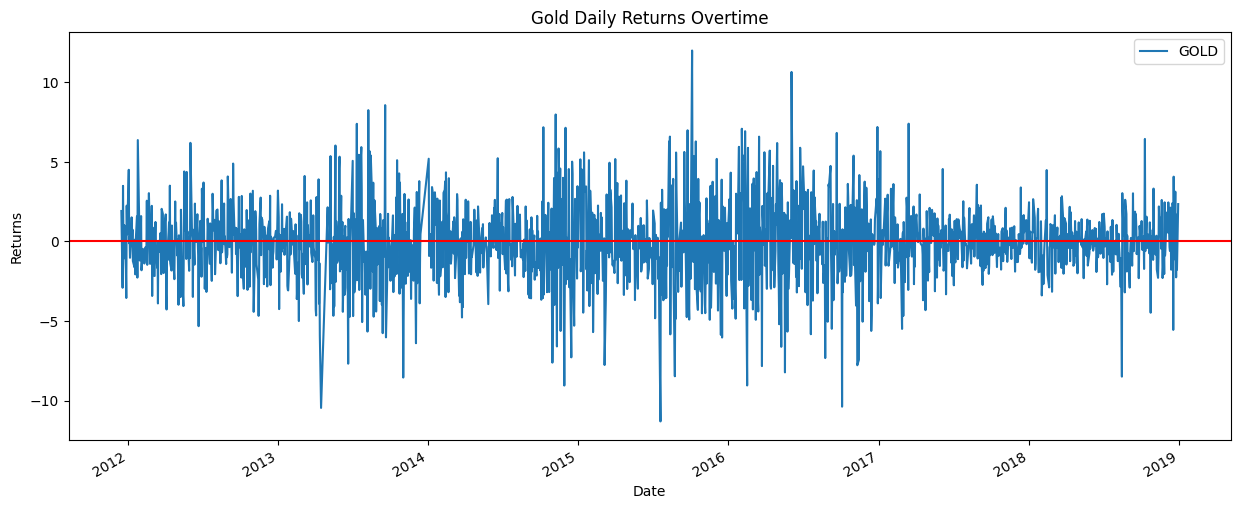

In [21]:
## Visualizing the log returns
fig, ax = plt.subplots(figsize=(15,6))
data["log_returns"].plot(ax=ax, label= "GOLD", color= "C0")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Gold Daily Returns Overtime")
plt.axhline(y=0, color="red", linestyle="-")
plt.legend();

### Summary statistics for the returns series
The retruns have a mean that's close to zero indicating no persistent trend.

The standard deviation of 2.45 shows moderate volatility.

Extreme values range from -11.31 to 12.00

The 75th percentile is slightly larger in magnitude that the 25th percentile indicating that positive returns are a bit more spread out than negative ones, slight asymmetry toward positive returns.

In [22]:
data["log_returns"].describe()

count    1717.000000
mean       -0.049067
std         2.452605
min       -11.309539
25%        -1.400645
50%        -0.046411
75%         1.285761
max        12.001768
Name: log_returns, dtype: float64

### Distribution of the returns series 
From the figure below, the histogram peaks at zero where most returns are, the spread of the histogram is not wider hence moderate volatility.
There are extreme returns, showing heavy-tailed behaviour.
The peak is sharper than a normal distribution

Using Fisher's excess Kurtosis, the kurtosis value is greater than 0, suggesting positive excess kurtosis and Leptokurtic distribution.

Overall the distribution suggests it might follow a Student's t distribution rather than a pure normal distribution.


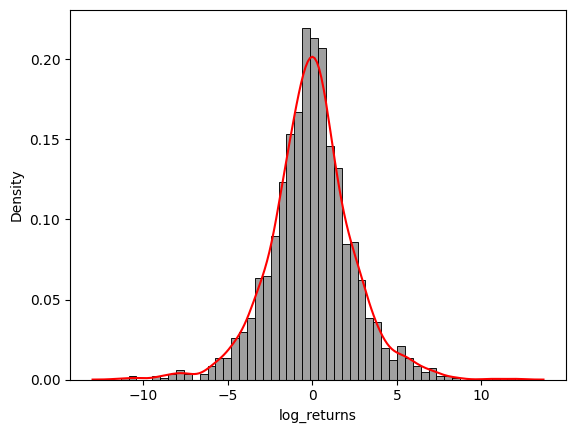

In [25]:
sns.histplot(data["log_returns"], bins=50, stat="density", fill=True, color="gray")
sns.kdeplot(data["log_returns"], color="r");

In [26]:
# Fisher's Excess Kurtosis
kurt =  data["log_returns"].kurtosis()
print(kurt)

1.899518126900082


### Checking for Stationarity
Augmented Dickey-Fuller test to confirm Stationarity of the returns series.

Setting the Hypothesis. An alpha of 0.05 is used as the default (95% confidence)

 1. **Null Hypothesis : The return series is non-stationary**
 2. **Alternative Hypothesis : The return series is stationary**

Results:
The p-value is less that 0.05 hence we reject the null, and conclude that the return series is Stationary.

In [27]:
result  = adfuller(data["log_returns"])
print (f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical values: {result[4]}')

if result[1] < 0.05 :
    print(f'Series is Stationary')
else:
    print(f'Series is not stationary')

Test Statistics: -24.100766706485487
p-value: 0.0
Critical values: {'1%': -3.4341709571201133, '5%': -2.86322773854977, '10%': -2.5676685057505693}
Series is Stationary


### Checking for Autocorrelation in the Squared return series
ACF plot and Ljung-Box testTest.

From the ACF Plot of the squared return series, most spikes are outside the confidence bands(evidence of volatility clustering).

Setting the Hypothesis. An alpha of 0.05 is used as the default (95% confidence)

 1. **Null Hypothesis : The squared return series has no autocorrelation**
 2. **Alternative Hypothesis : The squared return series has significant autocorrelation at one or more lags**

Results:
We can see that the p-value is less that 0.05 hence we reject the null hypothesis and conclude that the the squared return series has significant autocorrelation at one or more lag. This indicates volatility clustering in squared returns and hence GARCH model may be appropriate.

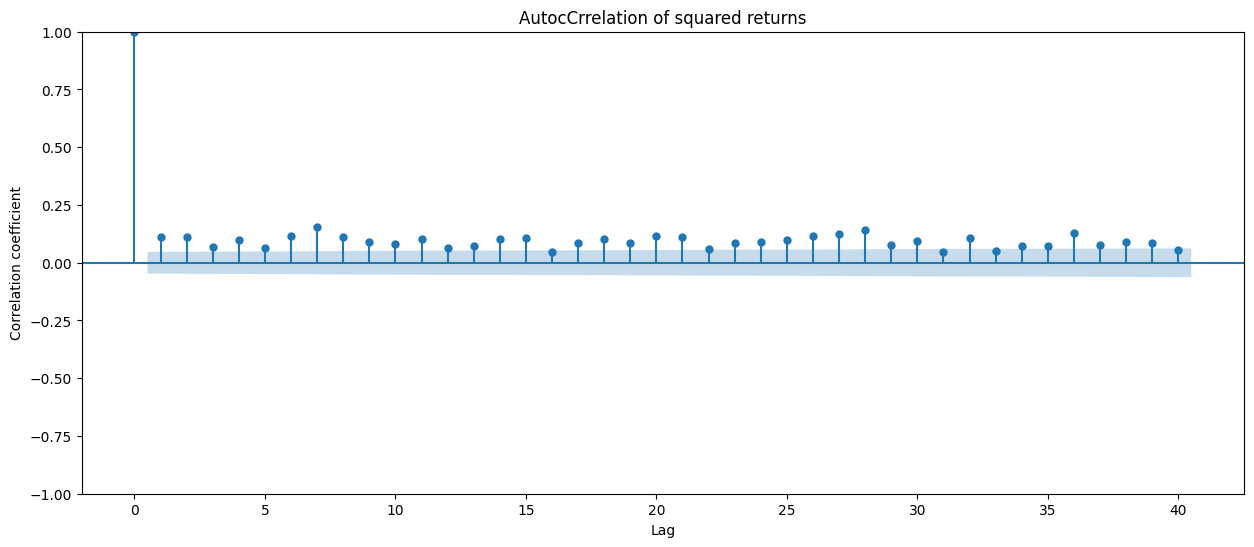

Ljung-Box test results for squared returns
       lb_stat      lb_pvalue
40  629.731588  4.589335e-107


In [28]:
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(data["log_returns"]**2,lags=40,ax=ax)
plt.title("AutocCrrelation of squared returns")
plt.xlabel("Lag")
plt.ylabel("Correlation coefficient")
plt.show()

print("Ljung-Box test results for squared returns")
print(acorr_ljungbox(data["log_returns"]**2,lags=[40], return_df=True))

### Splitting the data and fitting the model on training data
The data passed all the basic properties hence making it safe to fit a GARCH(1,1) model.
The mean model, mu is around zero
All the model parameters are greater than zero and significant.
alpha plus beta is very close to one and the volatility dynamics are well captured(past shocks and past variance)


In [86]:
# Using 80% train and 20% test
returns= data["log_returns"]
cutoff = int(len(returns) * 0.8)
train = returns.iloc[:cutoff]
test = returns.iloc[cutoff:] 
print("Total:",len(returns), "train:", len(train), "test:", len(test))

# Fit the baseline GARCH(1,1) model on train
model= arch_model(train, mean="constant", vol="GARCH", p=1, q=1, dist="t")
residuals= model.fit(update_freq=0, disp="off")
print(residuals.summary())

Total: 1717 train: 1373 test: 344
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                  log_returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3191.95
Distribution:      Standardized Student's t   AIC:                           6393.91
Method:                  Maximum Likelihood   BIC:                           6420.03
                                              No. Observations:                 1373
Date:                      Tue, Aug 26 2025   Df Residuals:                     1372
Time:                              13:34:00   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
---------------------------------------------------

### Checking for Autocorrelation in the Standardized squared residuals
ACF plot and Ljung-Box testTest.

Setting the Hypothesis. An alpha of 0.05 is used as the default (95% confidence)

1. **Null Hypothesis : The squared Standardized residuals has no autocorrelation**
2. **Alternative Hypothesis : The squared Standardized residuals has significant autocorrelation**
   
Results: The p-value is greater that 0.05 hence we fail to reject the null hypothesis and conclude that the Standardized squared residuals has no significant autocorrelation.
The GARCH model captured volatility clustering adequately.

From the ACF Plot, all spikes are within the confidence bands,suggesting no autocorrelation

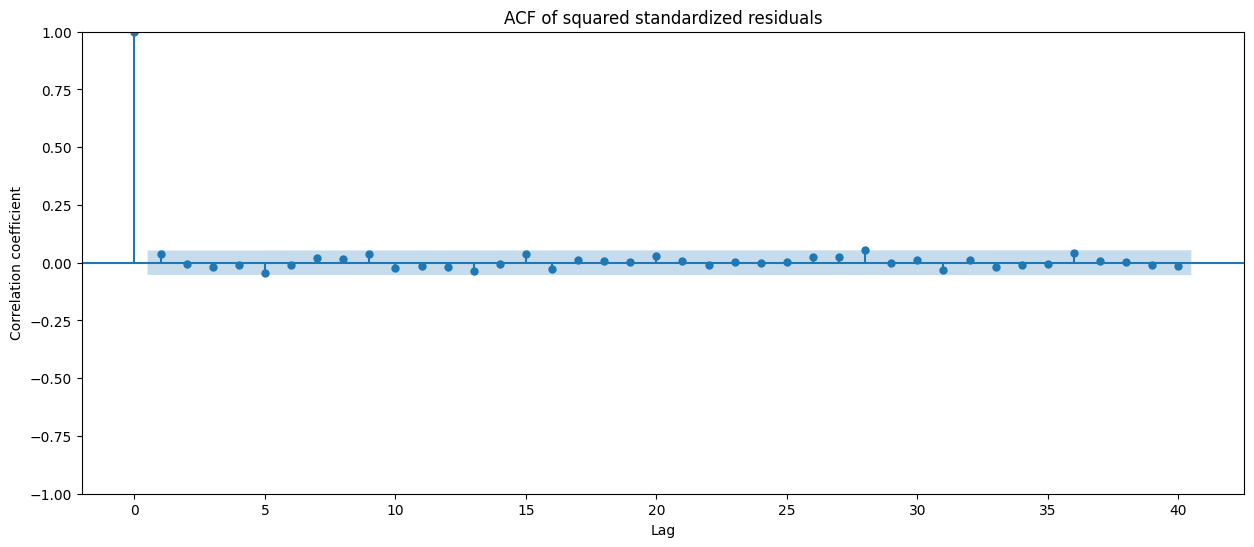

Ljung-Box test results for squared standardized residuals
      lb_stat  lb_pvalue
40  27.651188   0.930399


In [30]:
# Standardized residuals
std_residuals = residuals.std_resid.dropna()
# Checking for 
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(std_residuals**2,lags=40,ax=ax)
plt.title("ACF of squared standardized residuals")
plt.xlabel("Lag")
plt.ylabel("Correlation coefficient")
plt.show()

print("Ljung-Box test results for squared standardized residuals")
print(acorr_ljungbox(std_residuals**2,lags=[40], return_df=True))

### Testing for arch effects in the Standardized squared residuals

1. **Null Hypothesis : There are no Arch effects left**
2. **Alternative Hypothesis : Arch effects are present**

Results: The p-value is greater that 0.05 hence we fail to reject the null hypothesis and conclude that there are no Arch effects left in the residuals. The model is adequate as it has successfully captured the impact of past shocks.

In [31]:
arch_test = het_arch(std_residuals**2, nlags=10)
print("LM Statistic:", arch_test[0])
print("LM p-value:", arch_test[1])
print("F Statistic:", arch_test[2])
print("F p-value:", arch_test[3])

LM Statistic: 4.652529337275432
LM p-value: 0.9131491550441408
F Statistic: 0.4630788365901273
F p-value: 0.9140991379913082


### Checking if Standardized Residuals match the assumed Student's t distribution

From the QQ Plot below, the points follow the 45 degrees line quite closely with a few points away from the line at both ends suggesting heavier tails but nothing too dramatic. The residuals follow the t distribution well.
Overall the fit is good.

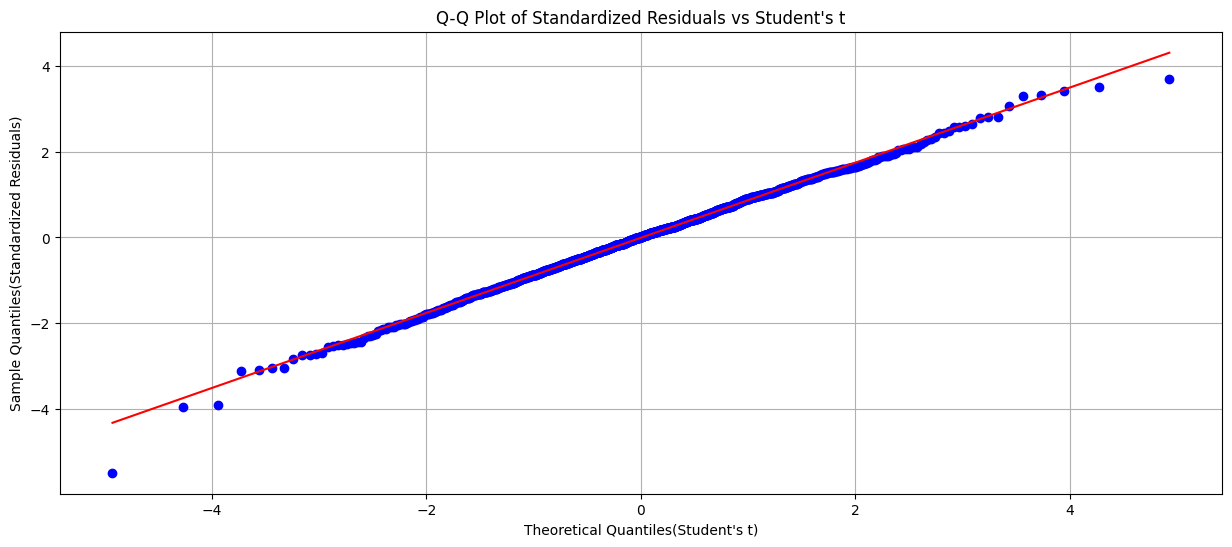

In [87]:
# degress of freedom from the fitted model
df = residuals.params["nu"]
# Plotting the
fig, ax = plt.subplots(figsize=(15,6))
stats.probplot(std_residuals, dist="t", sparams=(df,), plot=ax)
plt. title("Q-Q Plot of Standardized Residuals vs Student's t")
plt.xlabel("Theoretical Quantiles(Student's t)")
plt.ylabel("Sample Quantiles(Standardized Residuals)")
plt. grid(True)
plt.show()

### Out of sample forecasting using Rolling window walk-forward validation
Generating volatility forecasts for the whole test period only

In [88]:
# storage for forecasted
forecasts = [] 

for i in range(len(test)):

    train_window = returns.iloc[i : cutoff + i]  #rolling window

    # fit GARCH(1,1) model on this window
    model = arch_model(train_window, mean="constant", vol="GARCH", p=1, q=1, dist="t")
    res = model.fit(update_freq=0, disp="off") 

    # 1-step ahead variance forecast
    next_pred = res.forecast(horizon=1, reindex=False)
    one_step = float(next_pred.variance.iloc[0,0])
    
    forecasts.append(one_step)
    
# convert to forecast Series aligned with test and get their square root, for volatility series
forecasted_variance = pd.Series(forecasts, index=test.index)
forecasted_volatility = np.sqrt(forecasted_variance)

### Plotting the Forecasted Volatility vs Realized volatility
Both forecasted volatility and realized volatility move together, they rise and fall around the same periods hence the model tracks volatility clustering well.


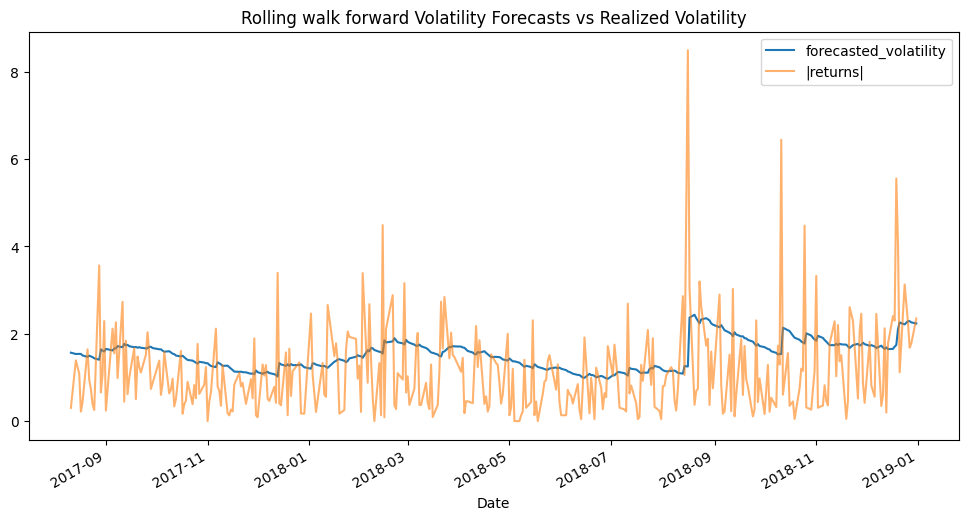

In [39]:
#forecast vs realized volatility
plt.figure(figsize=(12,6))
forecasted_volatility.plot(label="forecasted_volatility")
np.abs(test).plot(label= "|returns|", alpha=0.6) #volatility proxy
plt.legend()
plt.title("Rolling walk forward Volatility Forecasts vs Realized Volatility")
plt.show()

### Evaluating forecast accuracy using various metrics

In [40]:
realized_vol = np.abs(test) 
mse = mean_squared_error(realized_vol,forecasted_volatility)
mae = mean_absolute_error(realized_vol,forecasted_volatility)
qlike = (np.log(forecasted_variance) + (test**2) / (forecasted_variance)).mean()

print("MSE between forecast and realized volatility:", mse)
print("Rolling MAE:", mae)
print("Rolling QLIKE:", qlike)

MSE between forecast and realized volatility: 1.1939798023509969
Rolling MAE: 0.8515979874707188
Rolling QLIKE: 1.8078663814198765


### Monte Carlo Simulation
Simulating many possible Gold price paths across the entire test period using both drift(expected direction) and volatility(uncertainty).


In [102]:
# extract the whole Gold Price dataset
prices = data["GDX_Adj Close"]
cutoff1 = int(len(prices) * 0.8) # training set, first 80% data
train1  = prices.iloc[:cutoff1]
test1 = prices.iloc[cutoff1:]
S0 = train1.iloc[-1]  # take the last price in the training set before test set


mu_daily = train.mean() / 100.0 # estimate drift from the training returns
sigma_forecast_daily = forecasted_volatility.values / 100.0

np.random.seed(0)
n_paths = 5000
Forecast_days = len(sigma_forecast_daily)
nu = residuals.params["nu"]
paths =  np.zeros((Forecast_days+1, n_paths))
paths[0, :] = S0 #start all paths from the last training price

for T in range(1, Forecast_days+1):
    sigma_t = sigma_forecast_daily[T-1]
    z = student_t.rvs(df=nu, size=n_paths) / np.sqrt(nu / (nu-2)) # standardized student's t(mean 0, var 1)
    log_ret = (mu_daily - 0.5*sigma_t**2) + sigma_t * z
    paths[T, :] = paths[T-1, :] * np.exp(log_ret)

terminal_prices = paths[-1, :]
print("Mean:", terminal_prices.mean())
#print("10th-90th percentile:", np.percentile(terminal_prices, [10,90])) # calculate 10th and 90th percentile to get a forecast range
    

Mean: 18.757906550440545


### Plotting Actual Gold prices from the test set vs simulated price paths to check if actual prices fall within the forecasted bands
From the fan chart below I have summarized the simulated Gold price paths with percentiles(P5, P25,P50,P75,P95) scenarios.

P5-P95 is a 90% prediction interval, at each day 90%  of the simulated paths fall inside this band. 
P25-P75 is a 50% prediction interval, at each day half of the simulated paths fall inside this band

- The black line represents the actual test prices and it stayed within the 90% forecast band the entire period. This means the model captured uncertainty well. Overall, the spread or fan widens over time, suggesting higher uncertainty the further we go in time.

***The median forecast(P50) which is the most likely scenario, trends slightly downwards, the model expects mild decline on average.***

***The upper band (P95), which is the best case scenario, shows how high Gold prices could go if things turn out well (to approximately 27.5).***

***The lower band (P5) trends sharply down, it represents the worst case scenario, which is possible for the Gold prices dropping to approximately 12.5.***

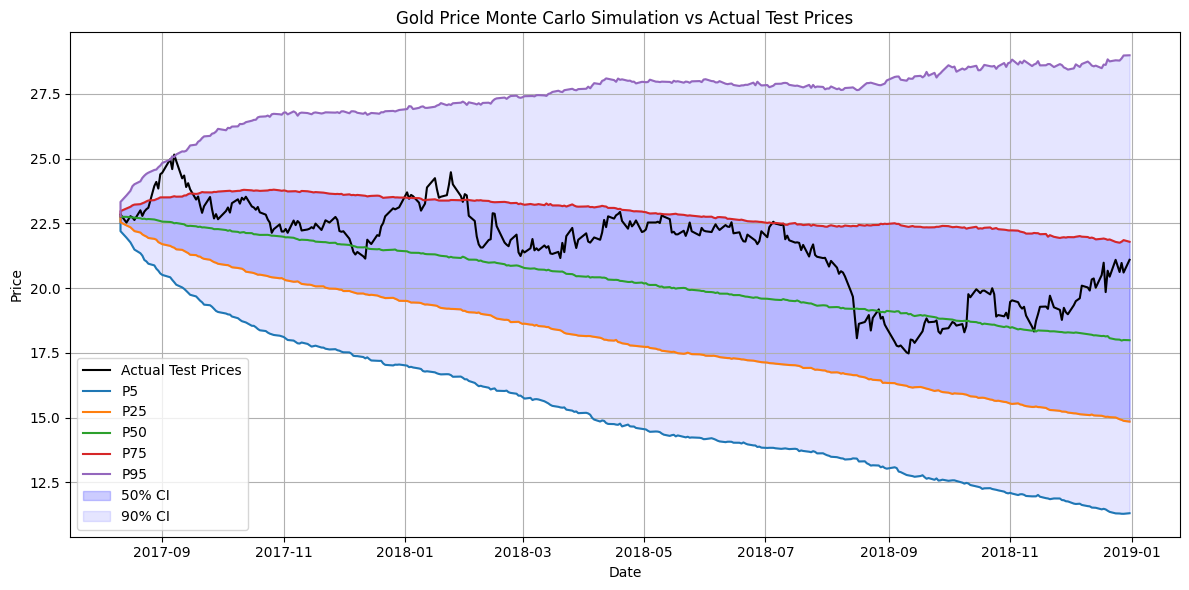

In [103]:
Percentiles = [5, 25, 50, 75, 95]
fan = np.percentile(paths, Percentiles, axis=1)

plt.figure(figsize=(12,6))

# Actual test prices
plt.plot(test1.index, test1.values, label="Actual Test Prices", color="black")
#fan chart(percentile paths)
for i, p in enumerate(Percentiles):
    plt.plot(test1.index.insert(0, test1.index[0]), fan[i], label=f"P{p}")

#shaded areas
plt.fill_between(test1.index.insert(0, test1.index[0]), fan[1], fan[3],
                color="blue", alpha=0.2, label="50% CI")
plt.fill_between(test1.index.insert(0, test1.index[0]), fan[0], fan[4],
                color="blue", alpha=0.1, label="90% CI")
plt.title("Gold Price Monte Carlo Simulation vs Actual Test Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()